In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Apr  7 07:12:25 2022

@author: sunnyguo
"""

import numpy as np

def bc_generator(para):
    #initial parameters: A, x0, sigx, longitude, latitudem frequency 
    #azimuth is longtitude; elevation is latitude
    azimuth = np.array(range(0,360))
    elevation = np.array(range(-90,91))
    freq = np.array(range(50,101))
    A, sigy = para[0]*(freq/75), para[1]
    y0 = 90

    elev = np.exp(-((elevation-y0)**2/(2*(sigy**2))))
    surface = np.tile(elev, (360,1)).T
    cube = np.tile(surface, (51,1,1))
    A_ = np.tile(A, (360,181,1))
    A_=A_.T
    cube = cube*A_
    return cube

def bc_flat(bc):
    return np.ndarray.flatten(bc)

def new_pg_collector(A,sigy):
    #parameters are in the form (A,sigx,sigy)
    Anew = np.repeat(A,len(sigy))
    sigynew = np.tile(sigy, len(A))
    parameters = np.column_stack((Anew,sigynew))
    freq = np.array(range(50,101))
    frequency = np.repeat(freq,65160)
    ele = np.array(range(-90,91))
    elev = np.repeat(ele,360)
    elevation = np.tile(elev,51)
    azi = np.array(range(0,360))
    azimuth = np.tile(azi, 9231)
    coordinates = np.column_stack((frequency,elevation,azimuth))
    for i in range(len(parameters)):
        beamcube = bc_generator(parameters[i])
        beamcube1D = bc_flat(beamcube)
        if i == 0:
            gains = beamcube1D
        else:
            gains = np.column_stack((gains, beamcube1D))
    return parameters, gains, coordinates


#_____________________________________________________________________________

def vec2mat_nd(vec,dims,ind):
    ndim=len(dims)
    while ind<0:
        ind+=ndim

    mat=np.empty(dims)-1
    if ind==0:
        left=''
    else:
        left=':,'*(ind)    
    if ind==ndim-1:
        right=''
    else:
        right=',:'*(ndim-ind-1)
    for i in range(len(vec)):
        myslice=left+repr(i)+right
        to_exec='mat['+myslice+']=vec['+repr(i)+']'
        exec(to_exec)
    return mat

def grid2mat(x):
    ndim=len(x)
    dims=[None]*ndim
    for i in range(ndim):
        dims[i]=len(x[i])
    n=np.product(dims)
    mat=np.zeros([n,ndim])
    for i in range(ndim):
        mat[:,i]=np.ravel(vec2mat_nd(x[i],dims,i))
    return mat

def make_A(x,ord):
    #print(x.shape)
    n=x.shape[0]
    # print('ord is ',ord)
    ord=np.asarray(ord,dtype='int')
    m=np.prod(ord+1)
    
    ndim=x.shape[1]
    A=np.ones([n,m])
    for i in range(m):
        mypows=np.unravel_index(i,ord+1)
        for j in range(ndim):
            A[:,i]=A[:,i]*x[:,j]**mypows[j]
    return A

def polyfitnd(x,y,ord):

    A=make_A(x,ord)
    lhs=A.T@A
    rhs=A.T@y
    fitp=np.linalg.inv(lhs)@rhs
    return fitp

def polyfitnd_grid(x,y,ord=None):

    if ord is None:
        #ndim=len(x)
        #dims=[None]*ndim
        #for i in range(ndim):
        #    ord[i]=len(x[i])-1
        ord=[len(z)-1 for z in x]
        print(ord)
    xx=grid2mat(x)
    return polyfitnd(xx,y,ord)

    dims=y.shape
    ndim=len(dims)
    assert(len(x)==ndim)
    for i in range(ndim):
        assert(len(x[i])==dims[i])
    #assert(len(y.shape)==ndim)
    #assert(np.sum(np.abs(dims-y.shape))==0)  #fails if x and y are different dimensions
             
    if ord is None:
        ord=dims
    if isinstance(ord,int):
        ord=np.asarray(np.ones(ndim)*ord,dtype='int')
    assert(len(ord)==ndim)
    print(ord)

    vecs=[None]*ndim
    for i in range(ndim):
        vecs[i]=vec2mat_nd(x[i],dims,i)

    return vecs
                          
def interp_weights(x,targ,ord):
    xx=np.vstack([x,targ])
    # print('xx shape is ',xx.shape)
    allA=make_A(xx,ord)
    # print('allA shape is ',allA.shape)
    A=allA[:-1,:]
    vec=allA[-1,:]
    lhs=A.T@A
    wts=vec@(np.linalg.inv(lhs)@(A.T))
    return wts

def interp_weights_grid(x,targ,ord=None):
    if ord is None:
        ord=[len(y)-1 for y in x]
    xx=grid2mat(x)
    wts=interp_weights(xx,targ,ord)
    return np.reshape(wts,np.asarray(ord,dtype='int')+1)
#return interp_weights(xx,targ,ord)

#---------------------------------------------------------------------------
def abm_interpolator(parameters, gains, interpolation_parameters, poly):
    
    # This function interpolates new beam models. As with pg_collector,
    # see the README for more detailed information on its use, or to my report
    # listed at the top. The current version (Version 3.0) does not rely upon the SVD method
    # as detailed in the report, but rather on polynd as written above by
    # Prof. Jon Sievers. This version simply calls the functions that he 
    # has written in polynd. The arguments of abm_interpolator are the same
    # as in the report, with addition of a new argument, "poly", described here:
        
    # New argument: poly - a 1xD list containing the order of the polynomial
    # used for interpolation for each dimension/parameter. Note that D follows
    # that reference in the report listed at the top of the script.
    
    # Ex) If I have D = 3 (i.e. I have three distinct parameters, as in blade 
    # length, blade separation, and soil conductivity) and I want a linear 
    # interpolation, poly = [1,1,1]. If instead I wanted a second-order 
    # polynomial in each parameter, I would set poly = [2,2,2].
    
    #-----------------------------------------------------------------------    
    # Version 3.0
    
    # This is the current version. It relies upon polynd as written by
    # Prof. Jon Sievers above.
    
    wts = interp_weights(parameters, interpolation_parameters, poly)
    interpolated_gains = gains @ wts
    
    return interpolated_gains

def read_n_interp(A, sigy, all_interpolation_parameters, poly):
    
    # This function calls both pg_collector and abm_interpolator at the 
    # same time. "all_interpolation_parameters" is a 2D array of parameters, 
    # each row being a different set of parameters you'd like to interpolate.
        
    parameters, gains, coordinates = new_pg_collector(A,sigy)
    
    # all_interpolated_gains is an array whose rows will be filled with the
    # interpolated gains corresponding to each row in all_interpolation_parameters. 
    # It has shape ((all_interpolation_parameters[0], len(gains))
    
    all_interpolated_gains = np.zeros((all_interpolation_parameters.shape[0], len(gains)))
    
    # for i in range(all_interpolation_parameters.shape[0]):
    #     all_interpolated_gains[i] = abm_interpolator(parameters, gains, all_interpolation_parameters[i], poly)
        
    for i in range(all_interpolation_parameters.shape[0]):
        wts = interp_weights(parameters, all_interpolation_parameters[i], poly)
        all_interpolated_gains[i] = gains @ wts
        
    return parameters, gains, coordinates, all_interpolated_gains

In [2]:
A = np.array([8,9,10])
sigy = np.array([35,45,55])
freq = np.array(range(50,101))
newpar = np.array([[9.5,40]])
elevation = np.array(range(-90,91))
poly11 = np.array([1,1])
poly12 = np.array([1,2])
poly21 = np.array([2,1])
poly22 = np.array([2,2])
poly33 = np.array([3,3])
poly13 = np.array([1,3])
poly23 = np.array([2,3])
poly31 = np.array([3,1])
poly32 = np.array([3,2])

In [3]:
paras, gains, coords, bg11 = read_n_interp(A, sigy, newpar, poly11)
paras, gains, coords, bg12 = read_n_interp(A, sigy, newpar, poly12)
paras, gains, coords, bg21 = read_n_interp(A, sigy, newpar, poly21)
paras, gains, coords, bg22 = read_n_interp(A, sigy, newpar, poly22)
paras, gains, coords, bg33 = read_n_interp(A, sigy, newpar, poly33)
paras, gains, coords, bg13 = read_n_interp(A, sigy, newpar, poly13)
paras, gains, coords, bg23 = read_n_interp(A, sigy, newpar, poly23)
paras, gains, coords, bg31 = read_n_interp(A, sigy, newpar, poly31)
paras, gains, coords, bg32 = read_n_interp(A, sigy, newpar, poly32)
reference_cube= bc_generator(newpar[0])

In [4]:
def table_cube(table):
    bc = np.reshape(table, (51,181,360))
    return bc

In [5]:
bc11 = table_cube(bg11[0])
bc12 = table_cube(bg12[0])
bc21 = table_cube(bg21[0])
bc22 = table_cube(bg22[0])
bc33 = table_cube(bg33[0])
bc13 = table_cube(bg13[0])
bc23 = table_cube(bg23[0])
bc31 = table_cube(bg31[0])
bc32 = table_cube(bg32[0])

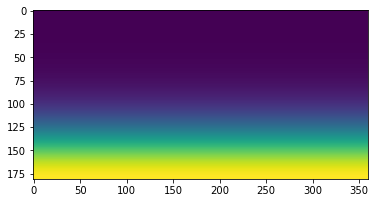

In [6]:
import matplotlib.pyplot as plt
from matplotlib import colors
plt.imshow(bc11[0])

In [7]:
def percentage(x,y):
    return 100*abs(x-y)/y

In [8]:
reference_cube[0][0]

array([0.00025375, 0.00025375, 0.00025375, 0.00025375, 0.00025375,
       0.00025375, 0.00025375, 0.00025375, 0.00025375, 0.00025375,
       0.00025375, 0.00025375, 0.00025375, 0.00025375, 0.00025375,
       0.00025375, 0.00025375, 0.00025375, 0.00025375, 0.00025375,
       0.00025375, 0.00025375, 0.00025375, 0.00025375, 0.00025375,
       0.00025375, 0.00025375, 0.00025375, 0.00025375, 0.00025375,
       0.00025375, 0.00025375, 0.00025375, 0.00025375, 0.00025375,
       0.00025375, 0.00025375, 0.00025375, 0.00025375, 0.00025375,
       0.00025375, 0.00025375, 0.00025375, 0.00025375, 0.00025375,
       0.00025375, 0.00025375, 0.00025375, 0.00025375, 0.00025375,
       0.00025375, 0.00025375, 0.00025375, 0.00025375, 0.00025375,
       0.00025375, 0.00025375, 0.00025375, 0.00025375, 0.00025375,
       0.00025375, 0.00025375, 0.00025375, 0.00025375, 0.00025375,
       0.00025375, 0.00025375, 0.00025375, 0.00025375, 0.00025375,
       0.00025375, 0.00025375, 0.00025375, 0.00025375, 0.00025

In [9]:
dbc11 = percentage(bc11, reference_cube)
dbc12 = percentage(bc12, reference_cube)
dbc21 = percentage(bc21, reference_cube)
dbc22 = percentage(bc22, reference_cube)
dbc33 = percentage(bc33, reference_cube)
dbc13 = percentage(bc13, reference_cube)
dbc23 = percentage(bc23, reference_cube)
dbc31 = percentage(bc31, reference_cube)
dbc32 = percentage(bc32, reference_cube)

In [10]:
wdbc11 = abs(bc11-reference_cube)
wdbc12 = abs(bc12-reference_cube)
wdbc21 = abs(bc21-reference_cube)
wdbc22 = abs(bc22-reference_cube)
wdbc33 = abs(bc33-reference_cube)
wdbc13 = abs(bc13-reference_cube)
wdbc23 = abs(bc23-reference_cube)
wdbc31 = abs(bc31-reference_cube)
wdbc32 = abs(bc32-reference_cube)

In [11]:
def max_dif(cube):
    lst = []
    for i in range(51):
        lst.append(np.max(cube[i]))
    return lst

In [12]:
def mean_map(cube):
    lst = []
    for i in range(51):
        lst.append(np.mean(cube[i]))
    return lst

In [13]:
def med_map(cube):
    lst = []
    for i in range(51):
        lst.append(np.median(cube[i]))
    return lst

In [14]:
# Mean Difference Cube
meanwdbc11 = mean_map(wdbc11)
meanwdbc12 = mean_map(wdbc12)
meanwdbc21 = mean_map(wdbc21)
meanwdbc22 = mean_map(wdbc22)
meanwdbc33 = mean_map(wdbc33)
meanwdbc13 = mean_map(wdbc13)
meanwdbc23 = mean_map(wdbc23)
meanwdbc31 = mean_map(wdbc31)
meanwdbc32 = mean_map(wdbc32)

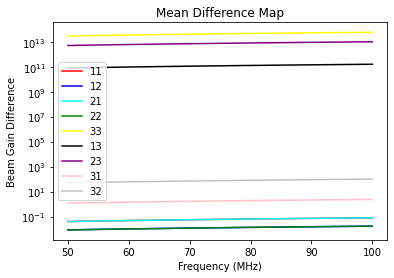

In [15]:
# Mean Difference Map
plt.title("Mean Difference Map")
plt.plot(freq, meanwdbc11, color = "red", label = "11")
plt.plot(freq, meanwdbc12, color = "blue", label = "12")
plt.plot(freq, meanwdbc21, color = "cyan", label = "21")
plt.plot(freq, meanwdbc22, color = "green", label = "22")
plt.plot(freq, meanwdbc33, color = "yellow", label = "33")
plt.plot(freq, meanwdbc13, color = "black", label = "13")
plt.plot(freq, meanwdbc23, color = "purple", label = "23")
plt.plot(freq, meanwdbc31, color = "pink", label = "31")
plt.plot(freq, meanwdbc32, color = "silver", label = "32")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Beam Gain Difference")
plt.yscale("log")
plt.legend()
plt.show()

In [16]:
# Median Difference Cube
medwdbc11 = med_map(wdbc11)
medwdbc12 = med_map(wdbc12)
medwdbc21 = med_map(wdbc21)
medwdbc22 = med_map(wdbc22)
medwdbc33 = med_map(wdbc33)
medwdbc13 = med_map(wdbc13)
medwdbc23 = med_map(wdbc23)
medwdbc31 = med_map(wdbc31)
medwdbc32 = med_map(wdbc32)

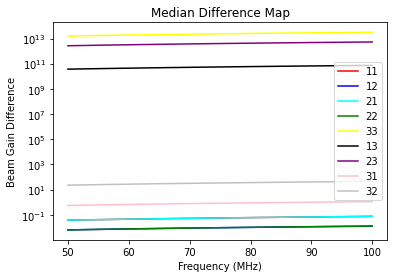

In [17]:
# Median Difference Map
plt.title("Median Difference Map")
plt.plot(freq, medwdbc11, color = "red", label = "11")
plt.plot(freq, medwdbc12, color = "blue", label = "12")
plt.plot(freq, medwdbc21, color = "cyan", label = "21")
plt.plot(freq, medwdbc22, color = "green", label = "22")
plt.plot(freq, medwdbc33, color = "yellow", label = "33")
plt.plot(freq, medwdbc13, color = "black", label = "13")
plt.plot(freq, medwdbc23, color = "purple", label = "23")
plt.plot(freq, medwdbc31, color = "pink", label = "31")
plt.plot(freq, medwdbc32, color = "silver", label = "32")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Beam Gain Difference")
plt.yscale("log")
plt.legend()
plt.show()

In [18]:
# Maximum Difference Cube
maxwdbc11 = max_dif(wdbc11)
maxwdbc12 = max_dif(wdbc12)
maxwdbc21 = max_dif(wdbc21)
maxwdbc22 = max_dif(wdbc22)
maxwdbc33 = max_dif(wdbc33)
maxwdbc13 = max_dif(wdbc13)
maxwdbc23 = max_dif(wdbc23)
maxwdbc31 = max_dif(wdbc31)
maxwdbc32 = max_dif(wdbc32)

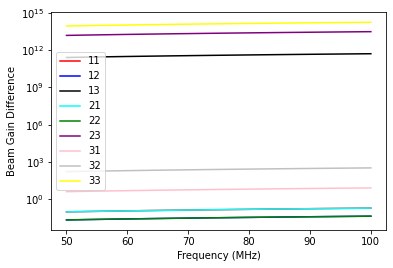

In [50]:
# Max Difference Map
plt.plot(freq, maxwdbc11, color = "red", label = "11")
plt.plot(freq, maxwdbc12, color = "blue", label = "12")
plt.plot(freq, maxwdbc13, color = "black", label = "13")
plt.plot(freq, maxwdbc21, color = "cyan", label = "21")
plt.plot(freq, maxwdbc22, color = "green", label = "22")
plt.plot(freq, maxwdbc23, color = "purple", label = "23")
plt.plot(freq, maxwdbc31, color = "pink", label = "31")
plt.plot(freq, maxwdbc32, color = "silver", label = "32")
plt.plot(freq, maxwdbc33, color = "yellow", label = "33")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Beam Gain Difference")
plt.yscale("log")
plt.legend()
plt.show()

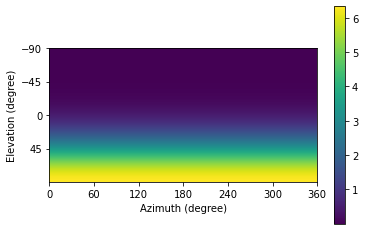

In [20]:
plt.imshow(reference_cube[0],extent = [0,360,90,-90])
plt.xlabel("Azimuth (degree)")
plt.ylabel("Elevation (degree)")
plt.xticks(np.arange(0, 370, step=60))
plt.yticks(np.arange(-90, 90, step=45))
plt.colorbar()
plt.show()

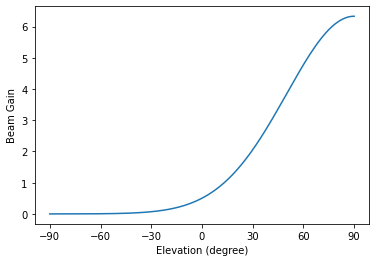

In [21]:
plt.plot(elevation,reference_cube[0,:,0])
plt.xlabel("Elevation (degree)")
plt.ylabel("Beam Gain")
plt.xticks(np.arange(-90, 91, step=30))
plt.show()

In [22]:
np.mean(dbc11[0,136:,:])

1.0841653437807894

In [23]:
np.mean(dbc11[0])

137.1131761486424

In [24]:
# Cutting Blocks
cdbc11 = dbc11[:,136:,:]
cdbc12 = dbc12[:,136:,:]
cdbc21 = dbc21[:,136:,:]
cdbc22 = dbc22[:,136:,:]
cdbc33 = dbc33[:,136:,:]
cdbc13 = dbc13[:,136:,:]
cdbc23 = dbc23[:,136:,:]
cdbc31 = dbc31[:,136:,:]
cdbc32 = dbc32[:,136:,:]

cwdbc11 = wdbc11[:,136:,:]
cwdbc12 = wdbc12[:,136:,:]
cwdbc21 = wdbc21[:,136:,:]
cwdbc22 = wdbc22[:,136:,:]
cwdbc33 = wdbc33[:,136:,:]
cwdbc13 = wdbc13[:,136:,:]
cwdbc23 = wdbc23[:,136:,:]
cwdbc31 = wdbc31[:,136:,:]
cwdbc32 = wdbc32[:,136:,:]

In [25]:
cdbc11.shape

(51, 45, 360)

In [26]:
# Mean Difference Partial Cube
meancwdbc11 = mean_map(cwdbc11)
meancwdbc12 = mean_map(cwdbc12)
meancwdbc21 = mean_map(cwdbc21)
meancwdbc22 = mean_map(cwdbc22)
meancwdbc33 = mean_map(cwdbc33)
meancwdbc13 = mean_map(cwdbc13)
meancwdbc23 = mean_map(cwdbc23)
meancwdbc31 = mean_map(cwdbc31)
meancwdbc32 = mean_map(cwdbc32)

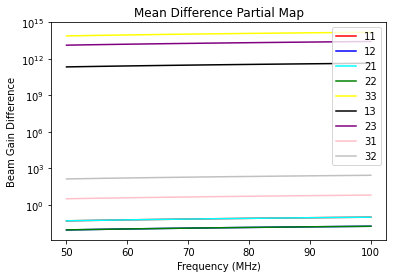

In [27]:
# Mean Difference Partial Map
plt.title("Mean Difference Partial Map")
plt.plot(freq, meancwdbc11, color = "red", label = "11")
plt.plot(freq, meancwdbc12, color = "blue", label = "12")
plt.plot(freq, meancwdbc21, color = "cyan", label = "21")
plt.plot(freq, meancwdbc22, color = "green", label = "22")
plt.plot(freq, meancwdbc33, color = "yellow", label = "33")
plt.plot(freq, meancwdbc13, color = "black", label = "13")
plt.plot(freq, meancwdbc23, color = "purple", label = "23")
plt.plot(freq, meancwdbc31, color = "pink", label = "31")
plt.plot(freq, meancwdbc32, color = "silver", label = "32")
plt.yscale("log")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Beam Gain Difference")
plt.legend()
plt.show()

In [28]:
print(f"[11:{max(meancwdbc11)},12:{max(meancwdbc12)},21:{max(meancwdbc21)},22:{max(meancwdbc22)},33:{max(meancwdbc33)},13:{max(meancwdbc13)},23:{max(meancwdbc23)},31:{max(meancwdbc31)},32:{max(meancwdbc32)}]")

[11:0.09812403049423202,12:0.01756750213545997,21:0.09812403122053623,22:0.017567451867245645,33:155015365879815.62,13:439165208757.1277,23:26864367429093.035,31:6.405131825962532,32:272.16034471112766]


In [29]:
# Median Difference Partial Cube
medcwdbc11 = med_map(cwdbc11)
medcwdbc12 = med_map(cwdbc12)
medcwdbc21 = med_map(cwdbc21)
medcwdbc22 = med_map(cwdbc22)
medcwdbc33 = med_map(cwdbc33)
medcwdbc13 = med_map(cwdbc13)
medcwdbc23 = med_map(cwdbc23)
medcwdbc31 = med_map(cwdbc31)
medcwdbc32 = med_map(cwdbc32)

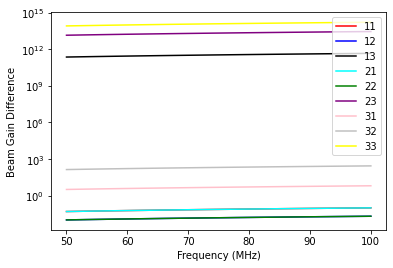

In [51]:
# Median Difference Partial Map
plt.plot(freq, medcwdbc11, color = "red", label = "11")
plt.plot(freq, medcwdbc12, color = "blue", label = "12")
plt.plot(freq, medcwdbc13, color = "black", label = "13")
plt.plot(freq, medcwdbc21, color = "cyan", label = "21")
plt.plot(freq, medcwdbc22, color = "green", label = "22")
plt.plot(freq, medcwdbc23, color = "purple", label = "23")
plt.plot(freq, medcwdbc31, color = "pink", label = "31")
plt.plot(freq, medcwdbc32, color = "silver", label = "32")
plt.plot(freq, medcwdbc33, color = "yellow", label = "33")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Beam Gain Difference")
plt.yscale("log")
plt.legend()
plt.show()

In [31]:
print(f"[11:{max(medcwdbc11)},12:{max(medcwdbc12)},21:{max(medcwdbc21)},22:{max(medcwdbc22)},33:{max(medcwdbc33)},13:{max(medcwdbc13)},23:{max(medcwdbc23)},31:{max(medcwdbc31)},32:{max(medcwdbc32)}]")




[11:0.10331233069186396,12:0.021290405530381307,21:0.1033123314235258,22:0.021290307885468707,33:159606629151336.9,13:453337069064.22766,23:27669678957920.91,31:6.620615885001973,32:280.9746745379359]


In [32]:
# Maximum Difference Partial Cube
maxcwdbc11 = max_dif(cwdbc11)
maxcwdbc12 = max_dif(cwdbc12)
maxcwdbc21 = max_dif(cwdbc21)
maxcwdbc22 = max_dif(cwdbc22)
maxcwdbc33 = max_dif(cwdbc33)
maxcwdbc13 = max_dif(cwdbc13)
maxcwdbc23 = max_dif(cwdbc23)
maxcwdbc31 = max_dif(cwdbc31)
maxcwdbc32 = max_dif(cwdbc32)

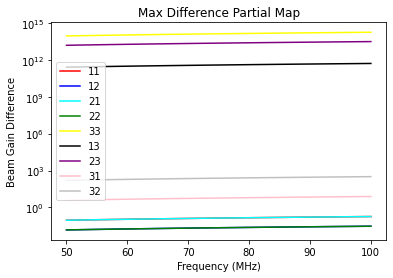

In [33]:
# Max Difference Partial Map
plt.title("Max Difference Partial Map")
plt.plot(freq, maxcwdbc11, color = "red", label = "11")
plt.plot(freq, maxcwdbc12, color = "blue", label = "12")
plt.plot(freq, maxcwdbc21, color = "cyan", label = "21")
plt.plot(freq, maxcwdbc22, color = "green", label = "22")
plt.plot(freq, maxcwdbc33, color = "yellow", label = "33")
plt.plot(freq, maxcwdbc13, color = "black", label = "13")
plt.plot(freq, maxcwdbc23, color = "purple", label = "23")
plt.plot(freq, maxcwdbc31, color = "pink", label = "31")
plt.plot(freq, maxcwdbc32, color = "silver", label = "32")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Beam Gain Difference")
plt.yscale("log")
plt.legend()
plt.show()

In [34]:
print(f"[11:{max(maxcwdbc11)},12:{max(maxcwdbc12)},21:{max(maxcwdbc21)},22:{max(maxcwdbc22)},33:{max(maxcwdbc33)},13:{max(maxcwdbc13)},23:{max(maxcwdbc23)},31:{max(maxcwdbc31)},32:{max(maxcwdbc32)}]")




[11:0.18278601642774994,12:0.02981531041085539,21:0.18278601718751997,22:0.0298152366093003,33:179163669358646.9,13:517418129156.51135,23:31129520332267.207,31:7.798756917317709,32:321.2011632720629]


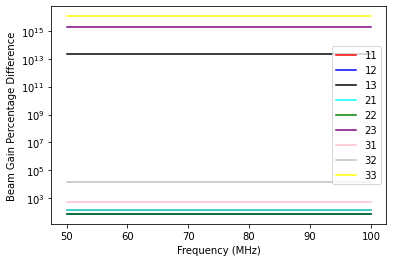

In [35]:
# Mean Percentage Difference Cube
meandbc11 = mean_map(dbc11)
meandbc12 = mean_map(dbc12)
meandbc21 = mean_map(dbc21)
meandbc22 = mean_map(dbc22)
meandbc33 = mean_map(dbc33)
meandbc13 = mean_map(dbc13)
meandbc23 = mean_map(dbc23)
meandbc31 = mean_map(dbc31)
meandbc32 = mean_map(dbc32)

# Mean Percentage Difference Map
plt.plot(freq, meandbc11, color = "red", label = "11")
plt.plot(freq, meandbc12, color = "blue", label = "12")
plt.plot(freq, meandbc13, color = "black", label = "13")
plt.plot(freq, meandbc21, color = "cyan", label = "21")
plt.plot(freq, meandbc22, color = "green", label = "22")
plt.plot(freq, meandbc23, color = "purple", label = "23")
plt.plot(freq, meandbc31, color = "pink", label = "31")
plt.plot(freq, meandbc32, color = "silver", label = "32")
plt.plot(freq, meandbc33, color = "yellow", label = "33")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Beam Gain Percentage Difference")
plt.yscale("log")
plt.legend()
plt.show()

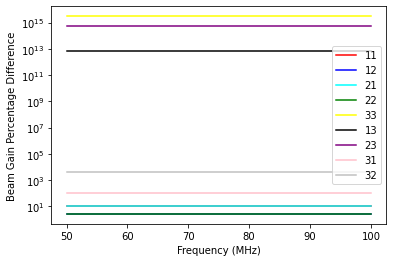

In [36]:
# Median Difference Percentage Cube
meddbc11 = med_map(dbc11)
meddbc12 = med_map(dbc12)
meddbc21 = med_map(dbc21)
meddbc22 = med_map(dbc22)
meddbc33 = med_map(dbc33)
meddbc13 = med_map(dbc13)
meddbc23 = med_map(dbc23)
meddbc31 = med_map(dbc31)
meddbc32 = med_map(dbc32)

# Median Difference Percentage Map
plt.plot(freq, meddbc11, color = "red", label = "11")
plt.plot(freq, meddbc12, color = "blue", label = "12")
plt.plot(freq, meddbc21, color = "cyan", label = "21")
plt.plot(freq, meddbc22, color = "green", label = "22")
plt.plot(freq, meddbc33, color = "yellow", label = "33")
plt.plot(freq, meddbc13, color = "black", label = "13")
plt.plot(freq, meddbc23, color = "purple", label = "23")
plt.plot(freq, meddbc31, color = "pink", label = "31")
plt.plot(freq, meddbc32, color = "silver", label = "32")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Beam Gain Percentage Difference")
plt.yscale("log")
plt.legend()
plt.show()

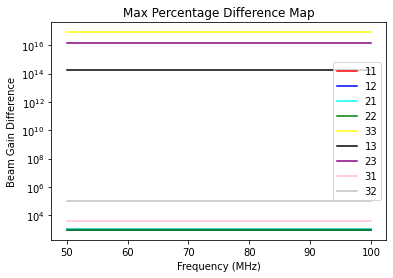

In [37]:
# Maximum Percentage Difference Cube
maxdbc11 = max_dif(dbc11)
maxdbc12 = max_dif(dbc12)
maxdbc21 = max_dif(dbc21)
maxdbc22 = max_dif(dbc22)
maxdbc33 = max_dif(dbc33)
maxdbc13 = max_dif(dbc13)
maxdbc23 = max_dif(dbc23)
maxdbc31 = max_dif(dbc31)
maxdbc32 = max_dif(dbc32)

# Maximum Percentage Difference Map
plt.title("Max Percentage Difference Map")
plt.plot(freq, maxdbc11, color = "red", label = "11")
plt.plot(freq, maxdbc12, color = "blue", label = "12")
plt.plot(freq, maxdbc21, color = "cyan", label = "21")
plt.plot(freq, maxdbc22, color = "green", label = "22")
plt.plot(freq, maxdbc33, color = "yellow", label = "33")
plt.plot(freq, maxdbc13, color = "black", label = "13")
plt.plot(freq, maxdbc23, color = "purple", label = "23")
plt.plot(freq, maxdbc31, color = "pink", label = "31")
plt.plot(freq, maxdbc32, color = "silver", label = "32")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Beam Gain Difference")
plt.yscale("log")
plt.legend()
plt.show()

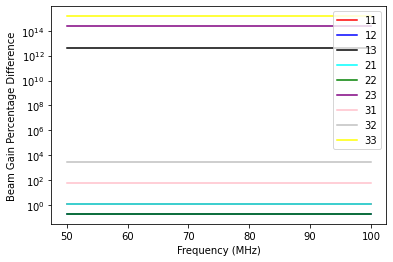

In [38]:
# Mean Percentage Difference Partial Cube
meancdbc11 = mean_map(cdbc11)
meancdbc12 = mean_map(cdbc12)
meancdbc21 = mean_map(cdbc21)
meancdbc22 = mean_map(cdbc22)
meancdbc33 = mean_map(cdbc33)
meancdbc13 = mean_map(cdbc13)
meancdbc23 = mean_map(cdbc23)
meancdbc31 = mean_map(cdbc31)
meancdbc32 = mean_map(cdbc32)

# Mean Percentage Difference Partial Map
plt.plot(freq, meancdbc11, color = "red", label = "11")
plt.plot(freq, meancdbc12, color = "blue", label = "12")
plt.plot(freq, meancdbc13, color = "black", label = "13")
plt.plot(freq, meancdbc21, color = "cyan", label = "21")
plt.plot(freq, meancdbc22, color = "green", label = "22")
plt.plot(freq, meancdbc23, color = "purple", label = "23")
plt.plot(freq, meancdbc31, color = "pink", label = "31")
plt.plot(freq, meancdbc32, color = "silver", label = "32")
plt.plot(freq, meancdbc33, color = "yellow", label = "33")
plt.yscale("log")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Beam Gain Percentage Difference")
plt.legend()
plt.show()

In [39]:
print(f"[11:{max(meancdbc11)},12:{max(meancdbc12)},21:{max(meancdbc21)},22:{max(meancdbc22)},33:{max(meancdbc33)},13:{max(meancdbc13)},23:{max(meancdbc23)},31:{max(meancdbc31)},32:{max(meancdbc32)}]")




[11:1.0841653437807985,12:0.18835852980239692,21:1.0841653509880926,22:0.18835798417707575,33:1488444063939691.0,13:4202159976312.259,23:257829501242122.4,31:60.94786390460231,32:2603.4143083749364]


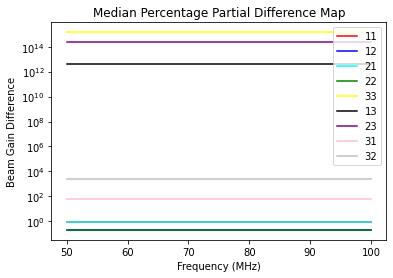

In [40]:
# Median Percentage Difference Partial Cube
medcdbc11 = med_map(cdbc11)
medcdbc12 = med_map(cdbc12)
medcdbc21 = med_map(cdbc21)
medcdbc22 = med_map(cdbc22)
medcdbc33 = med_map(cdbc33)
medcdbc13 = med_map(cdbc13)
medcdbc23 = med_map(cdbc23)
medcdbc31 = med_map(cdbc31)
medcdbc32 = med_map(cdbc32)

# Median Percentage Difference Partial Map
plt.title("Median Percentage Partial Difference Map")
plt.plot(freq, medcdbc11, color = "red", label = "11")
plt.plot(freq, medcdbc12, color = "blue", label = "12")
plt.plot(freq, medcdbc21, color = "cyan", label = "21")
plt.plot(freq, medcdbc22, color = "green", label = "22")
plt.plot(freq, medcdbc33, color = "yellow", label = "33")
plt.plot(freq, medcdbc13, color = "black", label = "13")
plt.plot(freq, medcdbc23, color = "purple", label = "23")
plt.plot(freq, medcdbc31, color = "pink", label = "31")
plt.plot(freq, medcdbc32, color = "silver", label = "32")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Beam Gain Difference")
plt.yscale("log")
plt.legend()
plt.show()

In [41]:
print(f"[11:{max(medcdbc11)},12:{max(medcdbc12)},21:{max(medcdbc21)},22:{max(medcdbc22)},33:{max(medcdbc33)},13:{max(medcdbc13)},23:{max(medcdbc23)},31:{max(medcdbc31)},32:{max(medcdbc32)}]")




[11:0.9488047662803676,12:0.20084851991377956,21:0.9488047729998496,22:0.20084808637884877,33:1465803060047030.2,13:4163378843350.071,23:254114132368415.25,31:60.905929958057605,32:2580.4287699285396]


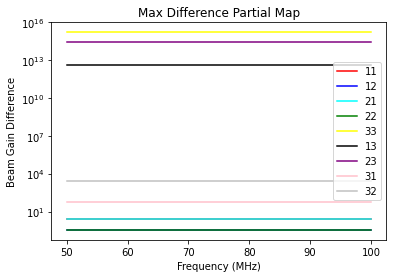

In [42]:
# Maximum Difference Partial Cube
maxcdbc11 = max_dif(cdbc11)
maxcdbc12 = max_dif(cdbc12)
maxcdbc21 = max_dif(cdbc21)
maxcdbc22 = max_dif(cdbc22)
maxcdbc33 = max_dif(cdbc33)
maxcdbc13 = max_dif(cdbc13)
maxcdbc23 = max_dif(cdbc23)
maxcdbc31 = max_dif(cdbc31)
maxcdbc32 = max_dif(cdbc32)

# Max Difference Partial Map
plt.title("Max Difference Partial Map")
plt.plot(freq, maxcdbc11, color = "red", label = "11")
plt.plot(freq, maxcdbc12, color = "blue", label = "12")
plt.plot(freq, maxcdbc21, color = "cyan", label = "21")
plt.plot(freq, maxcdbc22, color = "green", label = "22")
plt.plot(freq, maxcdbc33, color = "yellow", label = "33")
plt.plot(freq, maxcdbc13, color = "black", label = "13")
plt.plot(freq, maxcdbc23, color = "purple", label = "23")
plt.plot(freq, maxcdbc31, color = "pink", label = "31")
plt.plot(freq, maxcdbc32, color = "silver", label = "32")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Beam Gain Difference")
plt.yscale("log")
plt.legend()
plt.show()

In [43]:
print(f"[11:{max(maxcdbc11)},12:{max(maxcdbc12)},21:{max(maxcdbc21)},22:{max(maxcdbc22)},33:{max(maxcdbc33)},13:{max(maxcdbc13)},23:{max(maxcdbc23)},31:{max(maxcdbc31)},32:{max(maxcdbc32)}]")




[11:2.6011601919239133,12:0.34875771518337717,21:2.601160202823837,22:0.3487566559210097,33:1649311204485364.2,13:4469508124076.374,23:284164934017372.94,31:61.56913355777141,32:2760.248211815805]


In [44]:
logdbc11 = 10*np.log10(dbc11)
logdbc12 = 10*np.log10(dbc12)
logdbc21 = 10*np.log10(dbc21)
logdbc22 = 10*np.log10(dbc22)

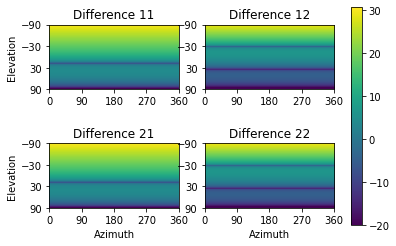

In [45]:
#@75 degree Difference
Nr = 2
Nc = 2
xticks = np.arange(0, 370, 90)
yticks = np.arange(-90, 91,60)
fig, axis = plt.subplots(Nr, Nc)
images = []
images.append(axis[0, 0].imshow(logdbc11[25], extent = [0,360,90,-90]))
axis[0, 0].set_title("Difference 11")
axis[0, 0].set(ylabel='Elevation')
images.append(axis[0, 1].imshow(logdbc12[25], extent = [0,360,90,-90]))
axis[0, 1].set_title("Difference 12")
images.append(axis[1,0].imshow(logdbc21[25], extent = [0,360,90,-90]))
axis[1, 0].set_title("Difference 21")
axis[1, 0].set(xlabel='Azimuth', ylabel='Elevation')
images.append(axis[1, 1].imshow(logdbc22[25], extent = [0,360,90,-90]))
axis[1, 1].set_title("Difference 22")
axis[1, 1].set(xlabel='Azimuth')
vmin = min(image.get_array().min() for image in images)
vmax = max(image.get_array().max() for image in images)
norm = colors.Normalize(vmin=-20, vmax=vmax)
for ax in axis.flat:
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
for im in images:
    im.set_norm(norm)
fig.colorbar(images[0], ax=axis, fraction=.1)
#fig.tight_layout()
plt.show()

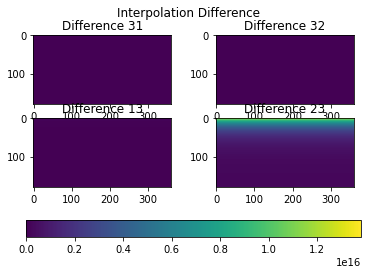

In [46]:
#@75 degree Difference
Nr = 2
Nc = 2
fig, axis = plt.subplots(Nr, Nc)
fig.suptitle('Interpolation Difference')
images = []
images.append(axis[0, 0].imshow(dbc31[25]))
axis[0, 0].set_title("Difference 31")
images.append(axis[0, 1].imshow(dbc32[25]))
axis[0, 1].set_title("Difference 32")
images.append(axis[1,0].imshow(dbc13[25]))
axis[1, 0].set_title("Difference 13")
images.append(axis[1, 1].imshow(dbc23[25]))
axis[1, 1].set_title("Difference 23")
vmin = min(image.get_array().min() for image in images)
vmax = max(image.get_array().max() for image in images)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
for im in images:
    im.set_norm(norm)
fig.colorbar(images[0], ax=axis, orientation='horizontal', fraction=.15)
plt.show()

In [47]:
x = np.max(bc11[0])

In [48]:
y = np.min(bc11[0][0])

In [49]:
x/y

1974.5922250463348